# P2 submission

---

**Requirements**
P2 submission notebook should show :
- That you can handle the data in its size.
- That you understand what’s in the data (formats, distributions, missing values, correlations, etc.).
- That you considered ways to enrich, filter, transform the data according to your needs.
- That you have a reasonable plan and ideas for methods you’re going to use, giving their essential mathematical details in the notebook.
- That your plan for analysis and communication is reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.



**Project proposal**

Best breweries in the world 

The idea behind the identification of the best breweries is that the consumer might be more interested to try new and/or original products that come from a good brewery. This ranking is based on the ratings given by the tasters, but the ratings have to be weighted by the number of ratings for the best beers, the quality and emotions transmitted in the text following the different ratings. Some ratings might be biased or unclear so some of them might have to be filtered. Once the ranking is determined a visualisation is to be created to convey properly the attributes of the best breweries (number of “quality” beers, rankings by styles).

*Feedback*

Find and visualize the best breweries - clarity: 75 - creativity: 75 - feasibility: 75, using beer-level reviews as a proxy for brewery reviews is doable, yet will require detailed analysis. 

---

# Beer reviews EDA

This dataset consists of beer reviews from two Beer rating websites: BeerAdvocate and RateBeer, for a period of 17 years ranging from 2001 to 2017.

Metadata about users, beers, and breweries (CSV)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import os
import spacy

# Handle size of the data

### Load ratings.txt

In [29]:
def load_txt_file(website):
    if website == 'BeerAdvocate':
        # Specify the directory containing the text files
        directory = './../dataset_BeerReviews/BeerAdvocate/rates_comp/'
    else:
        directory = './../dataset_BeerReviews/RateBeer/rates_comp/'

    # Initialize an empty list to store DataFrames
    dfs = []

    # Loop through the files in reverse order (ratings-5.txt to ratings-1.txt)
    for i in range(1, 0, -1):
        file_name = f'ratings-{i}.txt'
        file_path = os.path.join(directory, file_name)

        with open(file_path, 'r') as f:
            text = f.read()

        # Remove double quotes at the beginning of each line
        data = re.sub('"', '', text)
        data = re.sub(r'^"', '', data, flags=re.MULTILINE)

        # Split the text into individual beer reviews
        beer_reviews = data.split('beer_name')

        # Extract the beer information from each review
        beer_data = []
        for review in beer_reviews:
            beer_info = {}
            for line in [entry.split(':', 1) for entry in review.split('\n') if ':' in entry]:# and 'text' not in entry]:
                if line:  # Check if the list is not empty
                    key, value = line[0].strip(), line[1].strip()
                    beer_info[key] = value
            beer_data.append(beer_info)

        # Convert the beer data into a DataFrame
        df = pd.DataFrame(beer_data)

        # Append the DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    final_df = pd.concat(dfs, ignore_index=True)

    # Rename the columns
    final_df.columns = [
        'beer_name',
        'beer_id',
        'brewery_name',
        'brewery_id',
        'style',
        'abv',
        'date',
        'user_name',
        'user_id',
        'appearance',
        'aroma',
        'palate',
        'taste',
        'overall',
        'rating',
        'text']
    
    # sample the data
    df_sampled = final_df.sample(frac = 0.5, random_state=42)
    return df_sampled

ratings_BA = load_txt_file('BeerAdvocate')
ratings_RB = load_txt_file('RateBeer')

In [16]:
ratings_BA.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
262500,Brew Brothers Prairie Berry Ale,21927,Brew Brothers Brewing &#40;Alberta&#41;,3033,Fruit Beer,5.5,1044615600,presario,5348,3,6,3,7,13,3.20,Big blue 1L bottle. Very loud pop announced t...
39881,Ed Hardy Premium Beer,110849,Cervecería Mexicana (Grupo Modelo),5973,Pale Lager,4.6,1281520800,Cajun,47922,2,4,2,3,5,1.60,Tasting - Gulf Brew 2010 - Pale amber white he...


### Load the other data

In [8]:
# BeerAdvocate
beers_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/beers.csv")
breweries_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/breweries.csv")
users_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/users.csv")

# RateBeer
beers_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/beers.csv")
breweries_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/breweries.csv")
users_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/users.csv")

# matched_beer_data
beers_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/beers.csv", header=1)
breweries_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/breweries.csv", header = 1)
ratings_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/ratings.csv", header=1)
users_approx = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users_approx.csv", header=1)
users_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users.csv", header=1)

## EDA

Do univariate and multivariate analysis


- formats
- distributions
- missing values
- correlations
- etc...

**Organisation of the EDA**
- General data (users, breweries)
- Numerical ratings
- Textual reviews

In [37]:
def convert_type(df, col):
    df[col] = df[col].astype('float64')
    return df

cols = ['beer_id', 'brewery_id', 'abv', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

for col in cols : 
    ratings_BA = convert_type(ratings_BA, col)

In [38]:
def get_feature_stats(df):
    """
    Obtains descriptive statistics for all features and percentage of missing 
    values
    
    Parameters
    ----------
    df : DataFrame
         Containing all data

    Returns
    -------
    stats : DataFrame
            Containing the statistics for all features.
                   
    """
    ### BEGIN SOLUTION
    numerical = df.describe(include= ['float64', 'int64'])
    categorical = df.describe(include= ['object'])
    stats = pd.concat([numerical, categorical])
    #stats = df.describe(include= 'all') # alternative
    
    # Select the desired statistics
    stats = stats.loc[['mean', 'std', '50%', 'unique', 'top', 'freq']]
    percentage = df.isnull().sum(axis = 0)*100 / len(df)
    stats.loc['missing_values'] = np.array(percentage)
    ### END SOLUTION
    return stats

ratings_BA_stats = get_feature_stats(ratings_BA)
ratings_BA_stats

,beer_id,brewery_id,abv,user_id,appearance,aroma,palate,taste,overall,rating,beer_name,brewery_name,style,date,user_name,text
mean,143725.344100,6045.749160,6.131646,96268.179824,3.271979,6.060963,3.071590,6.141296,12.430836,3.097666,NaN,NaN,NaN,NaN,NaN,NaN
std,145079.490063,7227.633850,1.844538,104323.361684,0.834317,1.758270,0.850935,1.728032,3.599917,0.792787,NaN,NaN,NaN,NaN,NaN,NaN
50%,95893.000000,2300.000000,5.500000,60294.000000,3.000000,6.000000,3.000000,6.000000,13.000000,3.300000,NaN,NaN,NaN,NaN,NaN,NaN
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25438,1780,87,6021,12579,223086
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Corona Extra,Unibroue &#40;Sapporo&#41;,Pale Lager,1419764400,Lubiere,~This review was made some time ago via anothe...
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1796,14237,31158,154,2684,33
missing_values,0.000448,0.000448,0.000448,0.000448,0.000448,2.530014,0.000895,0.000895,0.000895,0.000895,0.000895,0.000895,0.000895,0.000895,0.000895,0.000895


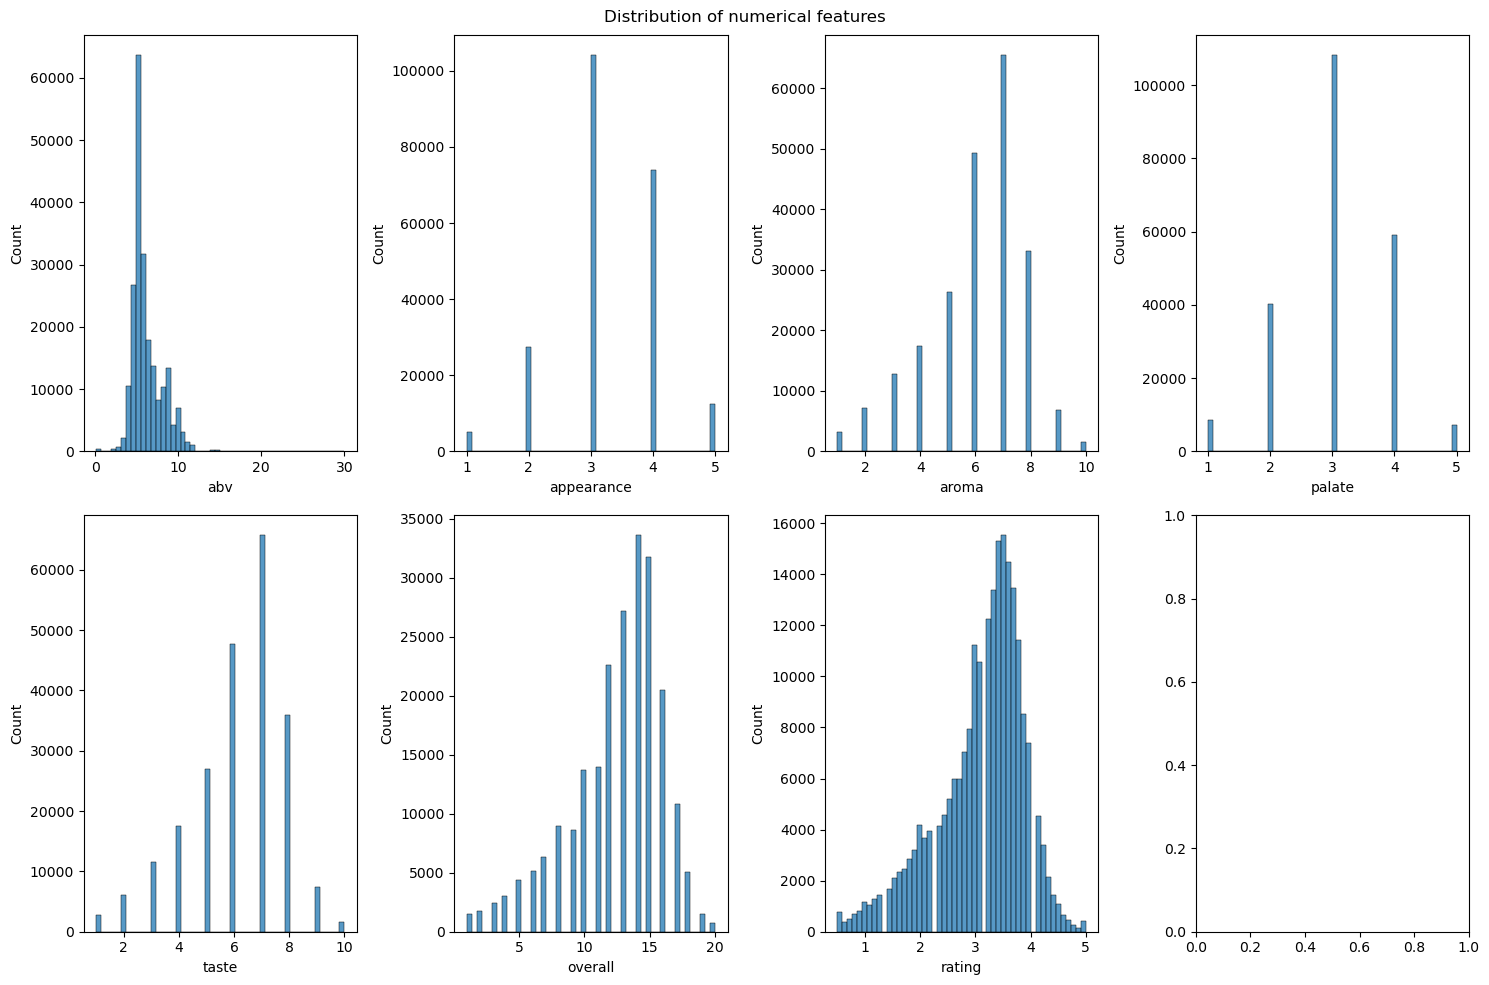

In [58]:
### 1.3
def plot_features(df, title):
    continuous_cols = ['abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating'] #list(df._get_numeric_data().columns)
    fig, axes = plt.subplots(2, 4, figsize=(15,10))
    for i, col in enumerate(continuous_cols):
        ax = axes[i // 4, i % 4]
        data = df[~df[col].isna()]
        sns.histplot(data=data[col], bins=50, ax=ax) #Filter out nan values in the features
    fig.suptitle(title)
    fig.tight_layout()
    return plt
    
plot_features(ratings_BA,"Distribution of numerical features")
plt.show()


### Textual reviews

- Number of words
- sentiment analysis (polarity, subjectivity)

In [59]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('stopwords') # Download NLTK stopwords
nltk.download('wordnet')   # Lemmatization

# Get the set of English stop words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [60]:
def preprocess_sentences(df, website):
    col_text = 'text' if website == 'BA' else 'text.1'
    
    # Step 1: Remove rows with no sentences (NaN values)
    df = df[~df[col_text].isnull()]

    # Step 2: Remove punctuation and convert to lowercase
    def clean_text(sentence):
        translator = str.maketrans('', '', string.punctuation)
        cleaned = sentence.translate(translator).lower()
        return cleaned

    # function to lemmatize 
    def lemmatize_text(sentence):
        tokens = word_tokenize(sentence)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(lemmatized_tokens)

    # Function to remove stop words
    def remove_stopwords(sentence):
        tokens = word_tokenize(sentence)
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
        return ' '.join(filtered_tokens)

    df['cleaned_text'] = df[col_text].apply(clean_text)
    df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)
    df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)
    
    return df

def compute_top_words(df):
    # Split the sentences into individual words
    all_words = ' '.join(df['cleaned_text']).split()

    # Count word occurrences
    word_counts = Counter(all_words)

    # Get the top 20 most common words
    top_words = word_counts.most_common(20)

    # Convert to DataFrame for easy plotting
    top_words_df = pd.DataFrame(top_words, columns=['Word', 'Count'])
    
    return top_words_df

In [62]:
import warnings
warnings.filterwarnings('ignore') # remove the warnings

ratings_BA_cleaned = preprocess_sentences(ratings_BA[:10000], website = 'BA')

warnings.filterwarnings('default')

In [64]:
ratings_BA_cleaned.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,cleaned_text
262500,Brew Brothers Prairie Berry Ale,21927.0,Brew Brothers Brewing &#40;Alberta&#41;,3033.0,Fruit Beer,5.5,1044615600,presario,5348.0,3.0,6.0,3.0,7.0,13.0,3.2,Big blue 1L bottle. Very loud pop announced t...,big blue 1l bottle loud pop announced office w...
39881,Ed Hardy Premium Beer,110849.0,Cervecería Mexicana (Grupo Modelo),5973.0,Pale Lager,4.6,1281520800,Cajun,47922.0,2.0,4.0,2.0,3.0,5.0,1.6,Tasting - Gulf Brew 2010 - Pale amber white he...,tasting gulf brew 2010 pale amber white head n...


In [ ]:
# Before preprocessing of the sentences
mean_words_BA = np.mean(ratings_BA["text"].apply(lambda row : len(str(row))))
mean_words_RB = np.mean(ratings_RB["text.1"].apply(lambda row : len(str(row))))
print(f"Average number of words in textual reviews of BA : {mean_words_BA}")
print(f"Average number of words in textual reviews of RB : {mean_words_RB}")

NaN_sentences_BA = len(ratings_BA[ratings_BA["text"].isnull()])
NaN_sentences_RB = len(ratings_RB[ratings_RB["text.1"].isnull()])
print(f"\nNumber of sentences with NaN/0 words in BA :{NaN_sentences_BA}")
print(f"Number of sentences with NaN/0 words in RB :{NaN_sentences_RB}")

# After preprocessing of the sentences
mean_words_BA = np.mean(ratings_BA_cleaned["cleaned_text"].apply(lambda row : len(str(row))))
mean_words_RB = np.mean(ratings_RB_cleaned["cleaned_text"].apply(lambda row : len(str(row))))
print(f"Average number of words in textual reviews of BA : {mean_words_BA}")
print(f"Average number of words in textual reviews of RB : {mean_words_RB}")

NaN_sentences_BA = len(ratings_BA_cleaned[ratings_BA_cleaned["cleaned_text"].isnull()])
NaN_sentences_RB = len(ratings_RB_cleaned[ratings_RB_cleaned["cleaned_text"].isnull()])
print(f"\nNumber of sentences with NaN/0 words in BA :{NaN_sentences_BA}")
print(f"Number of sentences with NaN/0 words in RB :{NaN_sentences_RB}")

fig, axs = plt.subplots(2,2, figsize=(10,6), sharex = True, sharey = True)
sns.histplot(data = ratings_BA['text'].apply(lambda row : len(str(row))), ax = axs[0,0])
sns.histplot(data = ratings_RB['text.1'].apply(lambda row : len(str(row))), ax = axs[0,1])
sns.histplot(data = ratings_BA_cleaned['cleaned_text'].apply(lambda row : len(str(row))), ax = axs[1,0])
sns.histplot(data = ratings_RB_cleaned['cleaned_text'].apply(lambda row : len(str(row))), ax = axs[1,1])

axs[0,0].set_title("Distrib. # words in BA ")
axs[0,1].set_title("Distrib. # words in RB")
axs[1,0].set_title("Distrib. # words in BA after cleaning")
axs[1,1].set_title("Distrib. # words in RB after cleaning")
plt.tight_layout()
plt.show()

## Data preprocessing

- enrichment
- filtering
- transformation

In [ ]:
# todo

## Feasibility check of project's methods
- give their essential mathematical details in the notebook.

In [ ]:
# todo

## Alternatives considered
- analysis and communication is reasonable

In [ ]:
# todo